In [1]:
import jax 
import jax.numpy as np 
from jax.random import normal
from jax import grad, hessian, vmap, pmap
from jax.flatten_util import ravel_pytree
from jax.lax import scan
from functools import partial
import jax.random as jax_random
import matplotlib.pyplot as plt 
from IPython.display import clear_output

import jaxopt

from kernel import RBF, create_kernel_matrix
from target_distributions import Uniform2D, TriModal2D
from mesh_distributions import BunnyMesh, SphereMesh

import polyscope as ps


objc[54180]: Class GLFWApplicationDelegate is implemented in both /Users/ia285/miniconda3/lib/python3.10/site-packages/open3d/cpu/pybind.cpython-310-darwin.so (0x282286e28) and /Users/ia285/miniconda3/lib/python3.10/site-packages/polyscope_bindings.cpython-310-darwin.so (0x2955bae68). One of the two will be used. Which one is undefined.
objc[54180]: Class GLFWWindowDelegate is implemented in both /Users/ia285/miniconda3/lib/python3.10/site-packages/open3d/cpu/pybind.cpython-310-darwin.so (0x282286db0) and /Users/ia285/miniconda3/lib/python3.10/site-packages/polyscope_bindings.cpython-310-darwin.so (0x2955bae90). One of the two will be used. Which one is undefined.
objc[54180]: Class GLFWContentView is implemented in both /Users/ia285/miniconda3/lib/python3.10/site-packages/open3d/cpu/pybind.cpython-310-darwin.so (0x282286e50) and /Users/ia285/miniconda3/lib/python3.10/site-packages/polyscope_bindings.cpython-310-darwin.so (0x2955baee0). One of the two will be used. Which one is undefin

# Unifrom

In [2]:
x0 =  np.array([0.14,0.15])
xf =  np.array([0.91,0.9])
T = 100
X_init = np.linspace(x0, xf, num=T, endpoint=True)
target_distribution = Uniform2D()
flat_X, unflatten_X = ravel_pytree(X_init)

X_samples = target_distribution.args['x_i']
P_XI      = target_distribution.args['p(x_i)']
h = 0.1
args = {'h' : h, 'X_samples' : X_samples, 'P_XI' : P_XI}
KernelMatrix = create_kernel_matrix(RBF)
def ergodic_mmd(flat_X, args):
    X_init = unflatten_X(flat_X)
    h = args['h']
    X_samples = args['X_samples']
    P_XI = args['P_XI']
    return np.sum(KernelMatrix(X_init, X_init, h))/(T**2) \
            - 2 * np.sum(P_XI @ KernelMatrix(X_init, X_samples, h))/T \
            + np.mean((X_init[1:]-X_init[:-1])**2)

I0000 00:00:1711648337.056767       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [8]:
solver = jaxopt.LBFGSB(fun=ergodic_mmd, maxiter=10_000, tol=1e-4)
bounds = (np.zeros_like(flat_X), np.ones_like(flat_X))
res= solver.run(flat_X, bounds=bounds, args=args)

KeyboardInterrupt: 

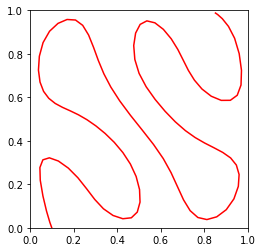

In [ ]:
X_init = unflatten_X(res.params)
plt.plot(X_init[:,0], X_init[:,1], 'r')
# plt.axis('equal')
plt.axis('square')
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig('uniform_search2D.png')

# Non Uniform

In [ ]:
x0 =  np.array([0.14,0.15])
xf =  np.array([0.91,0.9])
T = 100
X_init = np.linspace(x0, xf, num=T, endpoint=True)
target_distribution = TriModal2D()
flat_X, unflatten_X = ravel_pytree(X_init)

X_samples = target_distribution.args['x_i']
P_XI      = target_distribution.args['p(x_i)']
h = 0.01
args = {'h' : h, 'X_samples' : X_samples, 'P_XI' : P_XI}
KernelMatrix = create_kernel_matrix(RBF)
def ergodic_mmd(flat_X, args):
    X_init = unflatten_X(flat_X)
    h = args['h']
    X_samples = args['X_samples']
    P_XI = args['P_XI']
    return np.sum(KernelMatrix(X_init, X_init, h))/(T**2) \
            - 2 * np.sum(P_XI @ KernelMatrix(X_init, X_samples, h))/T \
            + np.mean((X_init[1:]-X_init[:-1])**2)
def ergodic_mmd(flat_X, args):
    X_init = unflatten_X(flat_X)
    h = args['h']
    X_samples = args['X_samples']
    # P_XI = args['P_XI']
    P_XI = vmap(target_distribution.p)(X_init)
    return 4.5*np.sum(KernelMatrix(X_init, X_init, h))/(T**2) \
            - 2 * np.sum(P_XI)/T \
            + np.mean((X_init[1:]-X_init[:-1])**2)

In [ ]:
solver = jaxopt.LBFGSB(fun=ergodic_mmd, maxiter=10_000, tol=1e-4)
bounds = (np.zeros_like(flat_X), np.ones_like(flat_X))
res= solver.run(flat_X, bounds=bounds, args=args)

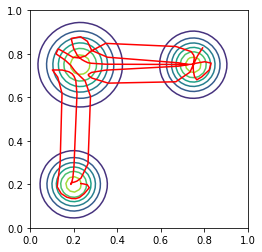

In [ ]:
X_init = unflatten_X(res.params)
target_distribution.plot()
plt.plot(X_init[:,0], X_init[:,1], 'r')

plt.axis('square')
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.savefig('nonuniform_search2D.png')

# Animation

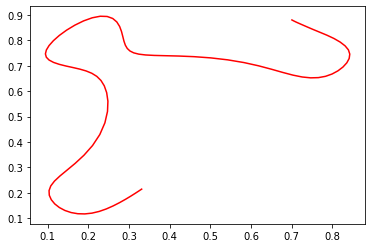

In [ ]:
x0 =  np.array([0.14,0.15])
xf =  np.array([0.91,0.9])
T = 100
X_init = np.linspace(x0, xf, num=T, endpoint=True)
target_distribution = Uniform2D()
flat_X, unflatten_X = ravel_pytree(X_init)

bounds = (np.zeros_like(flat_X), np.ones_like(flat_X))

solver = jaxopt.LBFGSB(fun=ergodic_mmd, maxiter=1000)
solver_state = solver.init_state(flat_X, bounds=bounds, args=args)
for _ in range(100): 
    (flat_X, solver_state) = solver.update(params=flat_X, state=solver_state, bounds=bounds, args=args)
    clear_output(wait=True)
    X_init = unflatten_X(flat_X)
    target_distribution.plot()
    plt.plot(X_init[:,0], X_init[:,1], 'r')
    plt.pause(0.001)

# Search on Mesh 

In [3]:
x0 =  np.array([0.54,0.45, 0.52])
xf =  np.array([0.66,0.535, 0.6])
T = 400
X_init = np.linspace(x0, xf, num=T, endpoint=True)
target_distribution = BunnyMesh()
flat_X, unflatten_X = ravel_pytree(X_init)

X_samples = target_distribution.args['x_i']
P_XI      = target_distribution.args['p(x_i)']
h = 0.1
args = {'h' : h, 'X_samples' : X_samples, 'P_XI' : P_XI}
KernelMatrix = create_kernel_matrix(RBF)
def ergodic_mmd(flat_X, args):
    X_init = unflatten_X(flat_X)
    T = X_init.shape[0]
    h = args['h']
    X_samples = args['X_samples']
    P_XI = args['P_XI']
    return np.sum(KernelMatrix(X_init, X_init, h))/(T**2) \
            - 2 * np.sum(P_XI @ KernelMatrix(X_init, X_samples, h))/T \
            + 0.1*np.mean((X_init[1:]-X_init[:-1])**2)

In [ ]:
solver = jaxopt.LBFGSB(fun=ergodic_mmd, maxiter=10_000, tol=1e-6)
bounds = (np.zeros_like(flat_X), np.ones_like(flat_X))
res= solver.run(flat_X, bounds=bounds, args=args)
X_init = unflatten_X(res.params)


KeyboardInterrupt: 

In [ ]:
# Visualize
ps.init()
ps_cloud = ps.register_point_cloud("my cloud", target_distribution.args['x_i'])
traj_cloud = ps.register_point_cloud("traj cloud", X_init)

# for i in range(n_eig):
    # ps_cloud.add_scalar_quantity("eigenvector_"+str(i), evecs[:,i], enabled=True)
ps.show()
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# X_init = unflatten_X(res.params)

# ax.scatter(X_init[:,0], X_init[:,1], X_init[:,2])

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.1 Metal - 88


# Animation 

In [4]:
x0 =  np.array([0.54,0.45, 0.52])
xf =  np.array([0.66,0.535, 0.6])
T = 400
X_init = np.linspace(x0, xf, num=T, endpoint=True)
target_distribution = BunnyMesh()
flat_X, unflatten_X = ravel_pytree(X_init)

bounds = (np.zeros_like(flat_X), np.ones_like(flat_X))

solver = jaxopt.LBFGSB(fun=ergodic_mmd, maxiter=1000)
solver_state = solver.init_state(flat_X, bounds=bounds, args=args)

# ps.set_always_redraw(True)
ps.init()
ps_cloud = ps.register_point_cloud("my cloud", target_distribution.args['x_i'])
traj_cloud = ps.register_point_cloud("traj cloud", X_init)

for _ in range(20000): 
    (flat_X, solver_state) = solver.update(params=flat_X, state=solver_state, bounds=bounds, args=args)
    X_init = unflatten_X(flat_X)
    traj_cloud.update_point_positions(X_init)
    ps.frame_tick()
    # plt.pause(0.001)

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.1 Metal - 88


KeyboardInterrupt: 